In [1]:
import torch
import torch.nn as nn
import pandas as pd
from keras.preprocessing.text import Tokenizer
from keras.preprocessing import sequence
from tqdm import tqdm
from torch.utils.data import Dataset
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
import numpy as np

2022-04-26 16:23:14.987014: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2022-04-26 16:23:14.987052: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.


In [2]:
class Preprocessing:
    
    def __init__(self, data_path, max_len, max_words):
        self.data = data_path
        self.max_len = max_len
        self.max_words = max_words
        
    def load_data(self):
        df = pd.read_csv(self.data)
        text = df['text'].values
        labels = df['humor'].values
        return text, labels
        
    def prepare_tokens(self, text):
        self.tokens = Tokenizer(num_words = self.max_words)
        self.tokens.fit_on_texts(text)
        
    def sequence_to_token(self, x):
        sequences = self.tokens.texts_to_sequences(x)
        return sequence.pad_sequences(sequences, maxlen = self.max_len)

In [3]:
class HumorDetector(nn.ModuleList):
    
    def __init__(self, batch_size, hidden_dim, LSTM_layers, input_size):
        super(HumorDetector, self).__init__()
        
        self.batch_size = batch_size
        self.hidden_dim = hidden_dim
        self.LSTM_layers = LSTM_layers
        self.input_size = input_size
        
        self.dropout = nn.Dropout(0.5)
        self.embedding = nn.Embedding(self.input_size, self.hidden_dim, padding_idx=0)
        self.lstm = nn.LSTM(input_size=self.hidden_dim, hidden_size=self.hidden_dim, num_layers=self.LSTM_layers, batch_first=True)
        self.lin1 = nn.Linear(self.hidden_dim, self.hidden_dim*2)
        self.lin2 = nn.Linear(self.hidden_dim*2, 2)
        self.softmax = nn.Softmax(dim = 1)
        
    def forward(self, x):
        h = torch.zeros((self.LSTM_layers, x.size(0), self.hidden_dim))
        c = torch.zeros((self.LSTM_layers, x.size(0), self.hidden_dim))
        
        torch.nn.init.xavier_normal_(h)
        torch.nn.init.xavier_normal_(c)
        
        out = self.embedding(x)
        out, (hidden, cell) = self.lstm(out, (h,c))
        out = self.dropout(out)
        out = torch.relu_(self.lin1(out[:,-1,:]))
        out = self.dropout(out)
#         out = torch.sigmoid(self.lin2(out))
        out = self.softmax(self.lin2(out))
        
        
        return out

In [4]:
# torch.autograd.set_detect_anomaly(True)
def training(model, loss_function, optimizer, n_epochs, update_interval, loader_training):
    
    losses = []
    avg_loss = []
    num_acc = 0
    for n in range(n_epochs):
        i = 0
        for x_batch, y_batch in (tqdm(loader_training)):

            optimizer.zero_grad()
            
            x = x_batch.type(torch.LongTensor)
            y = y_batch.type(torch.LongTensor)
#             if(y == prediction):
                
            
            my_output = model(x)
            _ , prediction = torch.max(my_output, 1)
#             print(prediction)
#             print(my_output)       
#             my_output[my_output > 0.5] = 1
#             my_output[my_output <= 0.5] = 0
#             print(my_output)
            loss = loss_function(my_output, y)
            loss.backward()
            optimizer.step()
            
            if i % update_interval == 0:
                losses.append(round(loss.item(), 2)) # This will append your losses for plotting -- please use "loss" as the name for your loss
                avg_loss.append(sum(losses)/len(losses))
            i += 1
        
    return model, losses, avg_loss

In [5]:
def calcAccuracy(model, loader_training):
        numAcc = 0
        i = 0
        totalnum = 0
        for x_batch, y_batch in (tqdm(loader_training)):
            optimizer.zero_grad()
            
            x = x_batch.type(torch.LongTensor)
            y = y_batch.type(torch.LongTensor)
            
            my_output = model(x)
            _ , prediction = torch.max(my_output, 1)
            for index in range(len(y)):
                totalnum = totalnum + 1
                if(prediction[index] == y[index]):
                    numAcc = numAcc + 1
        return numAcc/(totalnum)

In [6]:
class DatasetMapper(Dataset):
    def __init__(self, x, y):
        self.x = x
        self.y = y
    
    def __len__(self):
        return len(self.x)
    
    def __getitem__(self, i):
        return self.x[i], self.y[i]

In [7]:
#Hyperparameters
batch_size = 64
hidden_dim = 128
LSTM_layers = 2
lr = 1e-4
n_epochs = 1
update_interval = 32

preprocessing = Preprocessing("data/dataset.csv", 10, 100)
x_train, y_train = preprocessing.load_data()
preprocessing.prepare_tokens(x_train)
x_train = preprocessing.sequence_to_token(x_train)

training_set = DatasetMapper(x_train, y_train)
loader_training = DataLoader(training_set, batch_size=batch_size)

model = HumorDetector(batch_size, hidden_dim, LSTM_layers, 100)

loss_function = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=lr)

print("Accuracy before training: {}".format(calcAccuracy(model, loader_training)))

trained_model, losses, avg_loss = training(model, loss_function, optimizer, n_epochs, update_interval, loader_training)

print("Accuracy after training: {}".format(calcAccuracy(model, loader_training)))


100%|███████████████████████████████████████| 3125/3125 [01:15<00:00, 41.53it/s]


Accuracy before training: 0.487585


100%|███████████████████████████████████████| 3125/3125 [01:13<00:00, 42.37it/s]

Accuracy after training: 0.889495


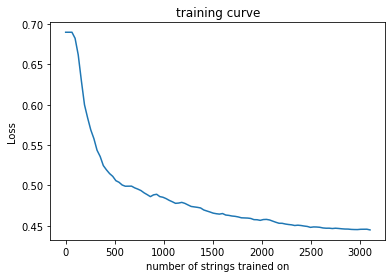

In [8]:
plt.plot(np.arange(len(losses)) * update_interval, avg_loss)
plt.title("training curve")
plt.xlabel("number of strings trained on")
plt.ylabel("Loss")
plt.show()

In [16]:
#Hyperparameter search - learning rate
possible_lrs = [1e-5, 2e-4, 5e-4, 1e-3, 5e-3, 1e-2]
lr_accuracies = []
for rate in possible_lrs:
    lr = rate
    model = HumorDetector(batch_size, hidden_dim, LSTM_layers, 100)
    loss_function = nn.CrossEntropyLoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=lr)
    trained_model, losses, avg_loss = training(model, loss_function, optimizer, n_epochs, update_interval, loader_training)
    lr_accuracies.append(calcAccuracy(model, loader_training))


100%|███████████████████████████████████████| 3125/3125 [01:20<00:00, 39.04it/s]


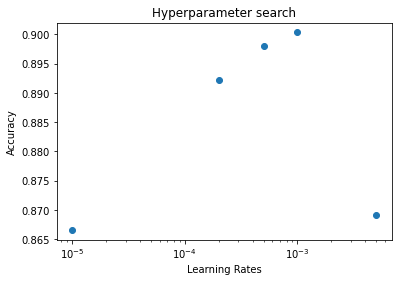

In [36]:
plt.scatter(possible_lrs[0:5], lr_accuracies[0:5])
plt.title("Hyperparameter search")
plt.xlabel("Learning Rates")
plt.ylabel("Accuracy")
plt.xscale('log')
plt.show()

In [ ]:
test_strings = ["How do you get a 100 cows into a barn? put up a bingo sign!",
                "People with high diabetes risk could lower heart risks by walking more each day: study"]
print("Funny value of a joke (funny):")
print(model(trained_model, test_strings, 0).item())
print("Funny value of a statement (not funny):")
print(model(trained_model, test_strings, 1).item())